In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import nibabel as nib
import numpy as np
import os
import random

In [6]:
path_to_images='/content/drive/My Drive/MIMRTL Lab/BOX Segmentations'
subject_paths = [i.path for i in os.scandir(path_to_images) if i.is_dir()]

#randomize order
random.seed(1)
random.shuffle(subject_paths)
print(subject_paths)

#which subjects should be validation 
#(note: careful not to include a subject's images in both train and validation)
validation_subjects = [0, 1, 2, 3]

['/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 27', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 115', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 95', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 96', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 23', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 101', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 94', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 102', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 92', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 116', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 26', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 84', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 87', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Patient 83', '/content/drive/My Drive/MIMRTL Lab/BOX Segmentations/Pat

In [ ]:
#use CV2 to resample the images
from cv2 import resize, INTER_LINEAR, INTER_NEAREST

resample_dims = 128

#initialize arrays (can erase later, but probably doesn't matter)
train_images = np.zeros((1,resample_dims, resample_dims,1))
train_masks =  np.zeros((1,resample_dims, resample_dims,1))
val_images = np.zeros((1,resample_dims, resample_dims,1))
val_masks = np.zeros((1,resample_dims, resample_dims,1))

#loop through, loading each subject's data
for i,subject in enumerate(subject_paths):

  #read a subject's stack of 2D images and stack of 2D masks, resize
  # https://chadrick-kwag.net/cv2-resize-interpolation-methods/
  image_stack = nib.load(subject + '/volume.nii.gz').get_fdata()
  image_stack_i = np.zeros((resample_dims, resample_dims, image_stack.shape[2]))

  #resize images
  for idx in range(image_stack.shape[2]):
    img = image_stack[:, :, idx]
    image_stack_i[:, :, idx] = resize(img, (resample_dims, resample_dims), interpolation=INTER_LINEAR)

  mask_stack = nib.load(subject + '/Segmentation.nii.gz').get_fdata()
  mask_stack_i = np.zeros((resample_dims, resample_dims, mask_stack.shape[2]))

  #resize masks
  for idx in range(mask_stack.shape[2]):
    mask = mask_stack[:, :, idx]
    mask_stack_i[:, :, idx] = resize(mask, (resample_dims, resample_dims), interpolation=INTER_NEAREST)
  
  #round masks to the nearest whole number (because mask numbers are not exactly whole numbers)
  mask_stack_i = np.around(mask_stack_i)

  #Normalize the data
  image_stack_i[image_stack_i < -1000] = -1000
  image_stack_i[image_stack_i > 3000] = 3000
  image_stack_i = (image_stack_i + 1000) / 4000.0

  #mask to segment: 1=liver, 2=bladder, 3=lungs
  mask = 1;
  mask_stack_i[mask_stack_i != mask] = 0
  mask_stack_i[mask_stack_i == mask] = 1
  
  #rearrange the data from (x_dim, y_dim, samples) into (samples, x_dim, y_dim)
  #https://numpy.org/doc/stable/reference/generated/numpy.moveaxis.html 
  print(image_stack_i.shape) 
  image_stack_i = np.moveaxis(image_stack_i, 2,0)
  mask_stack_i = np.moveaxis(mask_stack_i, 2,0)

  #this adds the channels dimension (may seem strange, but it is needed)
  #https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it
  image_stack_i = image_stack_i[:,:,:,np.newaxis]
  mask_stack_i = mask_stack_i[:,:,:,np.newaxis]

  #add images and masks, split into training and validation
  if i in validation_subjects:
    val_images = np.concatenate((val_images, image_stack_i), axis=0) 
    val_masks = np.concatenate((val_masks, mask_stack_i), axis=0)
  else:
    train_images = np.concatenate((train_images, image_stack_i), axis=0) 
    train_masks = np.concatenate((train_masks, mask_stack_i), axis=0)

(128, 128, 861)
(128, 128, 846)
(128, 128, 841)
(128, 128, 722)
(128, 128, 391)
(128, 128, 683)
(128, 128, 917)
(128, 128, 677)
(128, 128, 836)
(128, 128, 908)
(128, 128, 668)
(128, 128, 733)
(128, 128, 896)


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
batch_size = 32  
seed = 3

"""Augmentation on the dataset
Examples: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
https://github.com/kmjohnson3/ML4MI_BootCamp/blob/master/ImageModalityDetector/MRI_Modality_Detection_SOLUTION.ipynb
"""

# Arguments for augmentation
datagen_args = dict(rotation_range=10,  # rotation
                                   shear_range=5, # distortion
                                   width_shift_range=0.2,  # horizontal shift
                                   height_shift_range=0.2, # vertical shift
                                   zoom_range=0.2, # zoom
                                   fill_mode = 'nearest')  # zoom


image_datagen = ImageDataGenerator(**datagen_args)
mask_datagen = ImageDataGenerator(**datagen_args)

def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

def load_data(train):
  image_generator = image_datagen.flow(train_images[train,:,:,:], batch_size=batch_size, seed=seed, shuffle=True)
  mask_generator = mask_datagen.flow(train_masks[train,:,:,:], batch_size=batch_size, seed=seed, shuffle=True)
  return combine_generator(image_generator, mask_generator)

In [ ]:
print('Size of input images: ' + str(train_images.shape))
print('Size of input masks: ' + str(train_masks.shape))
print('Size of validation images: ' + str(val_images.shape))
print('Size of validation masks: ' + str(val_masks.shape))

Size of input images: (3096, 128, 128, 1)
Size of input masks: (3096, 128, 128, 1)
Size of validation images: (519, 128, 128, 1)
Size of validation masks: (519, 128, 128, 1)


{0.0: 16384}


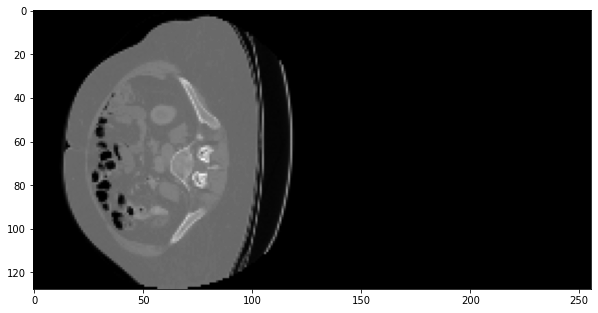

In [ ]:
from matplotlib import pyplot as plt
# set plotting to be in-line
%matplotlib inline

#view random slice, concatenating the image and mask next to each other
random_slice = random.randint(0,train_images.shape[0])
fig = plt.figure(figsize=(10,10))
unique, counts = np.unique(train_masks[random_slice,:,:,0], return_counts=True)
print(dict(zip(unique, counts)))
# np.concatenate: https://www.sharpsightlabs.com/blog/numpy-concatenate/
plt.imshow(np.concatenate((300*train_images[random_slice,:,:,0], 150*train_masks[random_slice,:,:,0]),axis=1), cmap='gray')
plt.show()


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.regularizers import l2

# also, import the Model function for building the model
from tensorflow.keras import Model

In [ ]:
# Dice loss function
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
def dicecoef_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    dice = (2. * intersection + 1e-5)/(K.sum(y_true_f) + K.sum(y_pred_f) + 1e-5)
    # We have calculated the dice coefficient, but we want to maximize it. 
    # Model fitting tries to minimize the loss so we simply return 1-dice
    return 1-dice

In [ ]:
def create_model():
  # create our input layer by giving it an input shape
  # https://www.tensorflow.org/api_docs/python/tf/keras/Input
  input_layer = Input(shape=train_images.shape[1:])

  #level 1
  conv1_en = Conv2D(8, 3, activation = 'relu', padding = 'same')(input_layer)
  pool1_en = MaxPooling2D(pool_size=(2, 2))(conv1_en)
  #level 2
  conv2_en = Conv2D(16, 3, activation = 'relu', padding = 'same')(pool1_en)
  pool2_en = MaxPooling2D(pool_size=(2, 2))(conv2_en)
  #level 3
  conv3_en = Conv2D(32, 3, activation = 'relu', padding = 'same')(pool2_en)
  pool3_en = MaxPooling2D(pool_size=(2, 2))(conv3_en)
  #level 4
  conv4_en = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool3_en)
  pool4_en = MaxPooling2D(pool_size=(2, 2))(conv4_en)

  #bottom level
  conv_bottom = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool4_en)

  #level 4 - DECODER
  # https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D

  up4_dec = UpSampling2D(size = (2,2))(conv_bottom)
  conv4_dec = concatenate([conv4_en,up4_dec])
  conv4_dec = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv4_dec)
  #level 3 - DECODER
  up3_dec = UpSampling2D(size = (2,2))(conv4_dec)
  conv3_dec = concatenate([conv3_en,up3_dec])
  conv3_dec = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv3_dec)
  #level 2 - DECODER
  up2_dec = UpSampling2D(size = (2,2))(conv3_dec)
  conv2_dec = concatenate([conv2_en,up2_dec])
  conv2_dec = Conv2D(16, 3, activation = 'relu', padding = 'same')(conv2_dec)
  #level 1 - DECODER
  up1_dec = UpSampling2D(size = (2,2))(conv2_dec)
  conv1_dec = concatenate([conv1_en,up1_dec])
  conv1_dec = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv1_dec)

  #output level
  conv_out = Conv2D(8, 3, activation = 'relu', padding = 'same')(conv1_dec)
  conv_out = Conv2D(1, 3, activation = 'sigmoid', padding='same')(conv_out)

  #define inputs/outpus
  # https://www.tensorflow.org/api_docs/python/tf/keras/Model
  unet = Model(inputs = input_layer, outputs = conv_out)
  unet.compile(loss=dicecoef_loss,optimizer=optimizers.Adam(learning_rate=1e-4))
  return unet

In [ ]:
import pandas as pd
def run_stats(mask):
  mean = []
  std = []
  for i in range(mask.shape[0]):
    mean.append(np.mean(mask[i,:,:,0]))
    std.append(np.std(mask[i,:,:,0]))
  dic = {'mean' : mean, 'std': std}
  return dic

In [ ]:
# Initialize variables
batch_size = 32
epochs = 30
allStats = []
n = 10

# Implement KFold with n splits
from sklearn.model_selection import KFold
kf = KFold(n_splits=n, shuffle=True)

# Run the model on each fold
for i, (train, test) in enumerate(kf.split(train_images, train_masks)):
    print ("Running Fold", i+1, "/", n)
    # generator for image and mask
    combinedGenerator = load_data(train)

    # reset model
    unet = None

    # create model
    unet = create_model()

    # run model
    history = unet.fit(combinedGenerator,
                  epochs=epochs,
                  steps_per_epoch=train.shape[0] // batch_size,
                  validation_data=(train_images[test,:,:,:], train_masks[test,:,:,:]),
                  verbose=1)

    # run evaluations
    score = unet.evaluate(val_images, val_masks, verbose = 1)
    print('Test loss: ', score)

    # run predictions
    predictions = unet.predict(val_images, verbose = 1)
    dic = run_stats(predictions)
    dic['Test loss'] = score

    # run stats
    allStats.append(dic)

Running Fold 1 / 10
Epoch 1/30
87/87 [==============================] - 43s 136ms/step - loss: 0.9422 - val_loss: 0.8618
Epoch 2/30
87/87 [==============================] - 12s 129ms/step - loss: 0.7478 - val_loss: 0.6504
Epoch 3/30
87/87 [==============================] - 11s 129ms/step - loss: 0.5710 - val_loss: 0.5308
Epoch 4/30
87/87 [==============================] - 11s 128ms/step - loss: 0.4926 - val_loss: 0.4787
Epoch 5/30
87/87 [==============================] - 11s 128ms/step - loss: 0.3951 - val_loss: 0.4427
Epoch 6/30
87/87 [==============================] - 11s 127ms/step - loss: 0.3464 - val_loss: 0.3895
Epoch 7/30
87/87 [==============================] - 11s 129ms/step - loss: 0.3005 - val_loss: 0.3225
Epoch 8/30
87/87 [==============================] - 11s 128ms/step - loss: 0.2763 - val_loss: 0.2970
Epoch 9/30
87/87 [==============================] - 11s 127ms/step - loss: 0.2668 - val_loss: 0.2617
Epoch 10/30
87/87 [==============================] - 11s 127ms/step - l

In [ ]:
allSplits = {}
for i in range(10):
  dic = allStats[i]
  splitstr = "Split " + str(i+1)
  allSplits[splitstr] = dic
df = pd.DataFrame(allSplits)
df.to_csv('/content/drive/My Drive/MIMRTL Lab/Andymask1.csv', index=False)

In [ ]:
for history in allHistory:
  # Plot the losses that are stored in the 'hist' variable
  plt.figure(figsize=(10,10));
  plt.plot(history.epoch,history.history['loss'],'b-s')
  plt.plot(history.epoch,history.history['val_loss'],'r-s')
  plt.legend(['Training Loss',
            ' Validation Loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Dice Coefficient')
plt.show()

In [ ]:
mean = np.mean(allLoss)
std = np.std(allLoss)
print("Mean test score across all folds: ", mean)
print("Standard deviation of test score across all folds: ", std)

In [ ]:

#show random images with the predicted results
random_slice = random.randint(0,train_images.shape[0] - 1)
fig = plt.figure(figsize=(10,10))
im_slice = train_images[random_slice,:,:,0]

# Prediction on Validation Set
true_mask_slice = train_masks[random_slice,:,:,0]

# Returning pixel value counts in true mask and predicted mask
unique, counts = np.unique(true_mask_slice, return_counts=True)
print(dict(zip(unique, counts)))
pred_mask_slice = predictions[random_slice,:,:,0]
unique, counts = np.unique(np.round(pred_mask_slice), return_counts=True)
print(dict(zip(unique, counts)))

""" Prediction on Training Set
true_mask_slice = train_masks[random_slice,:,:,0]
unique, counts = np.unique(true_mask_slice, return_counts=True)
print(dict(zip(unique, counts)))
pred_mask_slice = predictionsTrain[random_slice,:,:,0]
unique, counts = np.unique(np.round(pred_mask_slice), return_counts=True)
print(dict(zip(unique, counts)))
print("Min Max for Actual Mask", np.min(true_mask_slice), np.max(true_mask_slice))
print("Min Max for Predicted Mask", np.min(pred_mask_slice), np.max(pred_mask_slice))
"""

# https://numpy.org/doc/stable/reference/generated/numpy.c_.html
plt.imshow(np.c_[300 * im_slice, 300* true_mask_slice, 300 * np.round(pred_mask_slice)], cmap='gray')
plt.show()